## Import de la base de donnée et pré-traitement


In [116]:
import pandas as pd 
from src.utility.descriptive_statistics import descriptive_statistics
from src.graph.graph import plot_time_series

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

# Filtrage des dates spécifiques (outliers)
outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-02-01') & (df['index'] <= '2017-02-01')]


for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
0,1988-02-01,197.75,203.75,206.75,208.50,210.50
1,1988-02-02,198.25,203.75,206.75,207.50,209.75
2,1988-02-03,198.75,204.00,207.25,208.25,211.25
3,1988-02-04,202.75,207.75,210.75,212.50,216.00
4,1988-02-05,201.25,207.00,210.50,212.00,214.25
...,...,...,...,...,...,...
7309,2017-01-26,363.75,371.00,378.00,384.25,390.75
7310,2017-01-27,362.50,369.75,376.50,383.00,389.25
7311,2017-01-30,357.75,365.00,372.00,378.75,385.50
7312,2017-01-31,359.75,367.00,373.75,380.50,387.25


## Statistiques descriptives

In [117]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.4731,0.0001
Median,269.75,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.7495,0.0172
Skewness,1.53,-1.04
Kurtosis,1.57,19.59
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7313,7312


## Graphiques


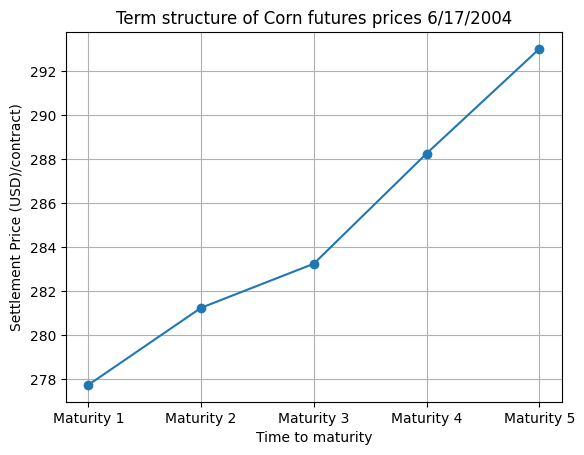

In [118]:
import matplotlib.pyplot as plt
df.set_index('index', inplace=True)
prix_17_06_2004 = df.loc['2004-06-17']

plt.plot(prix_17_06_2004.index, prix_17_06_2004.values, marker='o', linestyle='-')
plt.xlabel('Time to maturity')
plt.ylabel('Settlement Price (USD)/contract)')
plt.title('Term structure of Corn futures prices 6/17/2004')
plt.grid()
plt.show()

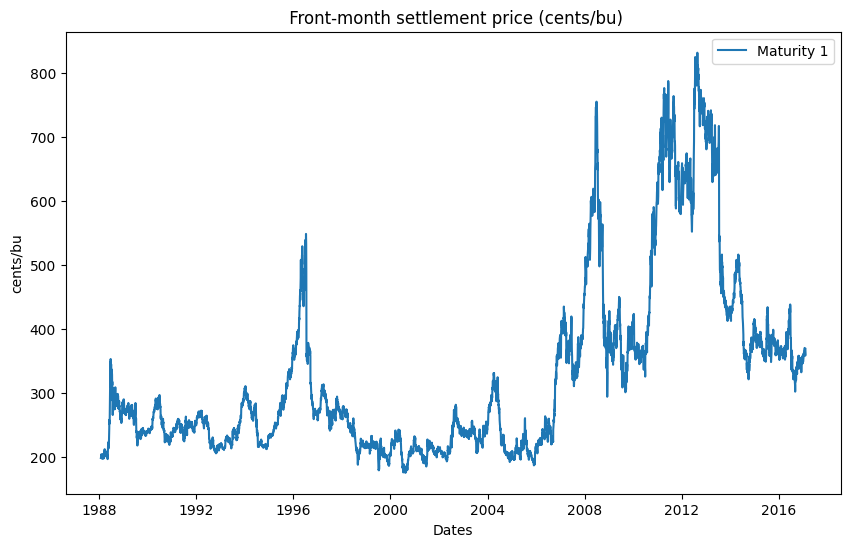

In [119]:
plot_time_series(df,["Maturity 1"], " Front-month settlement price (cents/bu)", "Dates", "cents/bu")